# Wagen Pendel Systemidentification mit SINDy
##  Linearisierte DGL
##  System mit Eingang

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps
import pickle
import random

import symbtools as st
import sympy as sp
import matplotlib.pyplot as plt
from sympy.interactive import printing
printing.init_printing()
%matplotlib inline

### Random Trajectory


In [2]:


def create_points(t, t0, tf, random_seed, n=None, ymax = .8):
    """ Create n points in the interval between t0 and tf with a maximum range of ymax. """
    
    if n == None:
        n = 2
    tt = np.linspace(t0, tf, n)
    points = []
    for t in tt:
        if t == t0 or t == tf:
            points.append((t, 0, 0, 0))
        else:
            random.seed(random_seed)
            y = random.uniform(-ymax, ymax)
            points.append((t, y, 0))
    return points

def create_input_function(random_seed, t0=0, tf=6, dt=1, ymax = 0.5):
    # create a polynomial for the input
    
    tt = np.arange(t0, tf, dt)
    n_p = 4 # points per interval
    t = sp.Symbol('t')
    # 
    poly_exprs = []
    for t1, t2 in zip(tt[:-1], tt[1::]): 
        # create 
        points = create_points(t, t0, dt, random_seed+t1, n_p, ymax)
        poly = st.condition_poly(t, *points)
        poly = poly.subs(t, t-t1)
        poly_exprs.append(poly.diff(t, 0))
    full_poly = st.create_piecewise(t, tt, (0, *poly_exprs, 0))
    full_poly_func = st.expr_to_func(t, full_poly)
    u_func = st.expr_to_func(t, full_poly.diff(t, 2))
    # print(full_poly)
    return u_func

### Systemgleichungen


In [3]:
system_read = pickle.load(open("wagen_pendel_a.p","rb"))
# input_func = create_input_function(1)
# %time rhs = system_read.create_simfunction(input_function=input_func)


### Trainingsdaten generieren

In [4]:
# Noise on/off?
noise = False
eps = .2 # Standardabweichung ||||    unter .2 ganz ok

tt = np.linspace(0, 5, 1000)
x_train_sequence = []
u_train_sequence = []
for i in range(0,10):
    random.seed(i)
    u_func_temp = create_input_function(i)
    rhs = system_read.create_simfunction(input_function=u_func_temp)
    xx0=[random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3)] # oder [0,0,0,0]
    x_train_set = odeint(rhs, xx0, tt) 
    if noise:
        x_train_set = x_train_set + np.random.normal(scale=eps, size=x_train_set.shape)
    x_train_sequence.append(x_train_set)
    u_train_set = u_func_temp(tt)
    u_train_sequence.append(u_train_set)
# print(data_sequence)

x_train = x_train_sequence
u_train = u_train_sequence
# print(u_train)


### Modellparameter einstellen

In [24]:
library_functions = [
    lambda x : x,
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x, y : np.cos(x)*y,
    lambda x, y : np.sin(x)*y
     
]
library_function_names = [
    lambda x : x,
    lambda x : 'sin(' + x + ')',
    lambda x : 'cos(' + x + ')',
    lambda x, y : y + ' * cos(' + x + ')',
    lambda x, y : y + ' * sin(' + x + ')'


]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

differentiation_method = ps.FiniteDifference(order=2)
# feature_library = ps.PolynomialLibrary(degree=9)
# feature_library = ps.FourierLibrary() 
feature_library = custom_library
# feature_library = ps.IdentityLibrary()


optimizer = ps.STLSQ(threshold=.5)

### fit model

In [26]:



model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["phi", "x", "phidot","xdot", "u"]
)
dt= 0.005
model.fit(x_train, u=u_train, t=dt, multiple_trajectories=True)
model.print()

phi' = 1.001 phidot
x' = 1.001 xdot
phidot' = -36.499 sin(phi) + -3.716 u * cos(phi)
xdot' = 1.000 u


### zu erwarten:
```
phi'    = 1 * phidot   
x'      = 1 * xdot  
phidot' = -36,482 * sin(phi) -3,7189 * cos(phi) * u  
xdot'   = 1 * u
```

In [43]:
random_seed_test = 85
random.seed(random_seed_test)
t_test = np.linspace(0, 5, 1000)
x0_test = [random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3)]

def u2(t):
    return np.sin(t)
u_func_test = create_input_function(random_seed_test, tf=11)
rhs_test = system_read.create_simfunction(input_function=u_func_test)
x_test = odeint(rhs_test, x0_test, t_test)
print(x_test.shape)
u_test = u_func_test(t_test)
print(u_test.shape)

(1000, 4)
(1000,)


Text(0.5, 0, 't')

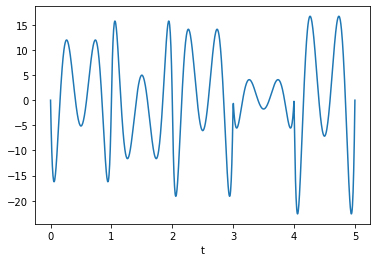

In [44]:

ax = plt.axis()
plt.plot(t_test, u_func_test(t_test), zorder=-1)
plt.xlabel('t')

In [45]:
# # Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test,u=u_test, t=dt))

Model score: 0.999995


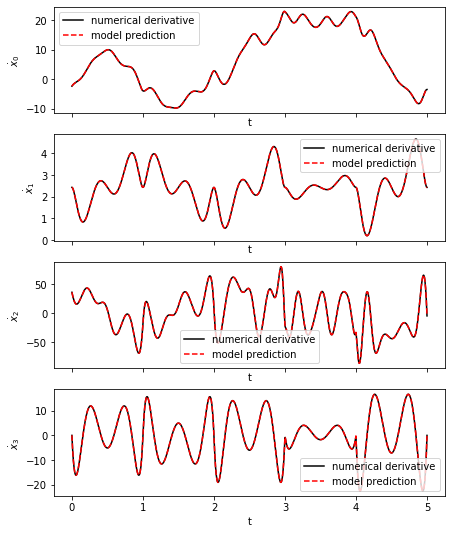

In [46]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test, u=u_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)


fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

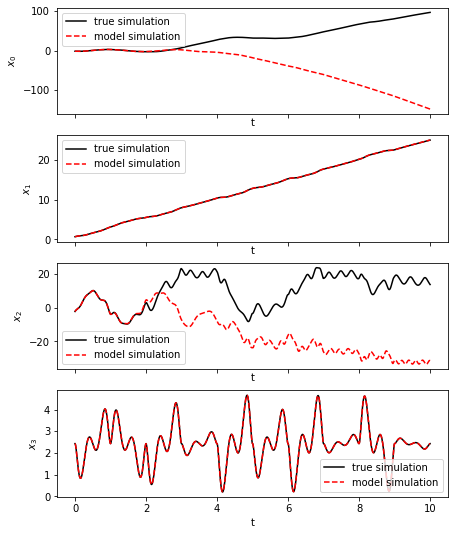

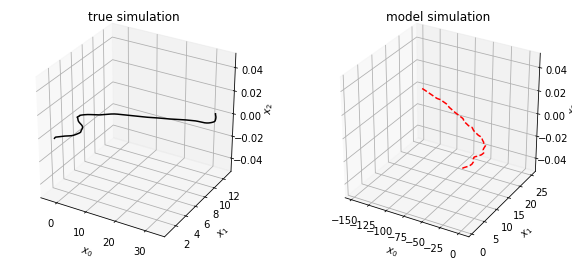

In [47]:
# Evolve the new initial condition in time with the SINDy model
t_evolve = np.linspace(0, 10, 2000)
u_func_test = create_input_function(random_seed_test, tf=11)
rhs_evolve = system_read.create_simfunction(input_function=u_func_test)
x_evolve = odeint(rhs_evolve, x0_test, t_evolve)
u_test = u_func_test(t_evolve)


x_test_sim = model.simulate(x0_test, t_evolve, u=u_func_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_evolve, x_evolve[:, i], 'k', label='true simulation')
    axs[i].plot(t_evolve, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1],  'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

Wall time: 43.3 ms


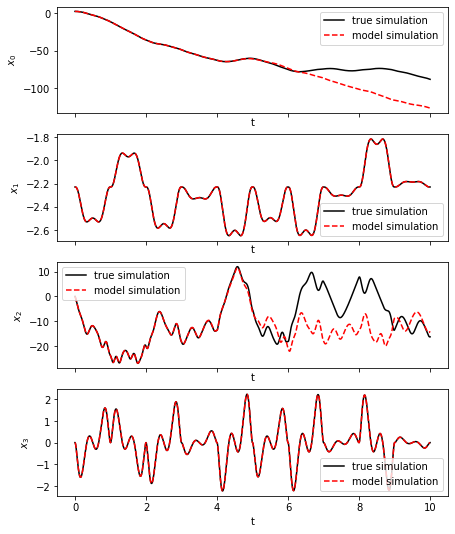

In [48]:
# Evolution in Time DIY
random.seed(random_seed_test)
g = 9.81
s2 = 0.26890449
#
tt = np.linspace(0, 10, 20000)
system_read = pickle.load(open("wagen_pendel_a.p","rb"))
input_func = create_input_function(random_seed_test, tf=11)
%time rhs_ = system_read.create_simfunction(input_function=input_func)
# ax = plt.axis()
# plt.plot(tt, input_func(tt), zorder=-1)
# plt.plot(tt, input_func(tt), zorder=-1)
# plt.xlabel('t')

def u(t):
    return input_func(t)
def model_ident(x, t):
    return[
        1.001*x[2],
        1.001*x[3],
        -36.487*np.sin(x[0]) -3.714* u(t)*np.cos(x[0]),
        u(t)
    ]
def model_known(x, t):
    return[
        1.00*x[2],
        1.00*x[3],
        -g/s2*np.sin(x[0]) -1/s2* u(t)*np.cos(x[0]),
        u(t)
    ]


x0_model_ident = [random.uniform(-3,3),random.uniform(-3,3),0,0]#random.uniform(-3,3),random.uniform(-3,3)]
x0_system_func = x0_model_ident

model_ident_data = odeint(model_ident, x0_model_ident, tt)
system_func_data = odeint(rhs_, x0_system_func, tt)


fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(tt, system_func_data[:, i], 'k', label='true simulation')
    axs[i].plot(tt, model_ident_data[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))



plt.legend()
plt.show()